# 02. Financial Data Structures 

### 대상 종목 

* A122630 KODEX 레버리지(ISIN: KR7122630007)
* A252670 KODEX 200선물인버스2X(ISIN: KR7252670005)
* A233740 KODEX 코스닥150레버리지(ISIN: KR7233740000)
* A251340 KODEX 코스닥150선물인버스(ISIN: KR7251340006)
* A005930 삼성전자(ISIN:KR7005930003)




In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

import pandas as pd 
import datetime
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
plt.style.use('bmh')

import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

from numba import jit
from tqdm import tqdm, tqdm_notebook
from datetime import datetime

pd.set_option('display.max_rows', 100)

## Load Tick Data

In [4]:
# TRADE_A122630 = pd.read_parquet('/nfs/data/interim/TRADE_A122630.parq')
TRADE_A233740 = pd.read_parquet('/nfs/data/interim/TRADE_A233740.parq')
# TRADE_A252670 = pd.read_parquet('/nfs/data/interim/TRADE_A252670.parq')
# TRADE_A251340 = pd.read_parquet('/nfs/data/interim/TRADE_A251340.parq')


In [5]:
TRADE_A233740.shape

(11946001, 6)

In [6]:
TRADE_A233740.tail()

,TIME,PRICE,BID,ASK,V,DV
11945996,2018-12-28 15:19:57,11965,11960,11965,16,191440
11945997,2018-12-28 15:19:57,11965,11960,11965,2000,23930000
11945998,2018-12-28 15:19:57,11965,11965,11970,540,6461100
11945999,2018-12-28 15:19:58,11965,11965,11970,500,5982500
11946000,2018-12-28 15:19:59,11965,11965,11970,10,119650


In [7]:
df = TRADE_A233740

In [8]:
df.set_index('TIME', inplace=True)

## Outlier modification



In [9]:
@jit(nopython=True)
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh


In [10]:
mad = mad_outlier(df.PRICE.values.reshape(-1, 1))
df.loc[~mad].shape

(11946001, 5)

## Tick Bars 

In [11]:
def tick_bars(df, price_col, n): 
    '''
    compute tick bars 
    '''    
    prices = df[price_col]
    tick_n = 0
    idx = []
    for i, x in enumerate(tqdm(prices)): 
        tick_n += 1
        if tick_n >= n: 
            idx.append(i)
            tick_n = 0
            continue
    return df.iloc[idx]


    

In [12]:
df_tick = tick_bars(df, 'PRICE', 100)

100%|██████████| 11946001/11946001 [00:04<00:00, 2397281.78it/s]


In [39]:
def select_sample_data(ref, sub, price_col, date): 
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    return xdf, xtdf

def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return


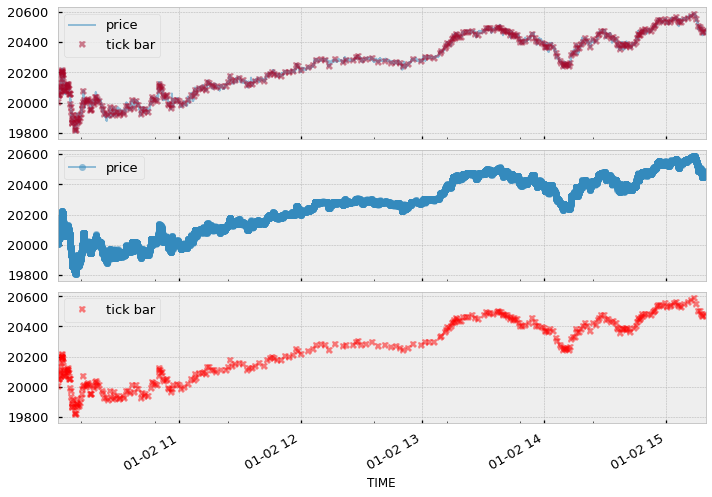

In [15]:
xdf, xtdf = select_sample_data(df, df_tick, 'PRICE', '2018-01-02')
plot_sample_data(xdf, xtdf, 'tick bar', alpha=0.5, markersize=7)

## Volume Bars 

In [16]:
def volume_bars(df, volume_col, n): 
    'compute volume bars'
    
    vols = df[volume_col]
    tick_n = 0
    idx = []
    for i, x in enumerate(tqdm(vols)): 
        tick_n += x 
        if tick_n >= n: 
            idx.append(i)
            tick_n = 0
            continue
            
    return df.iloc[idx]


In [17]:
df_vbar = volume_bars(df, 'V', 10000)


100%|██████████| 11946001/11946001 [00:05<00:00, 2341360.09it/s]


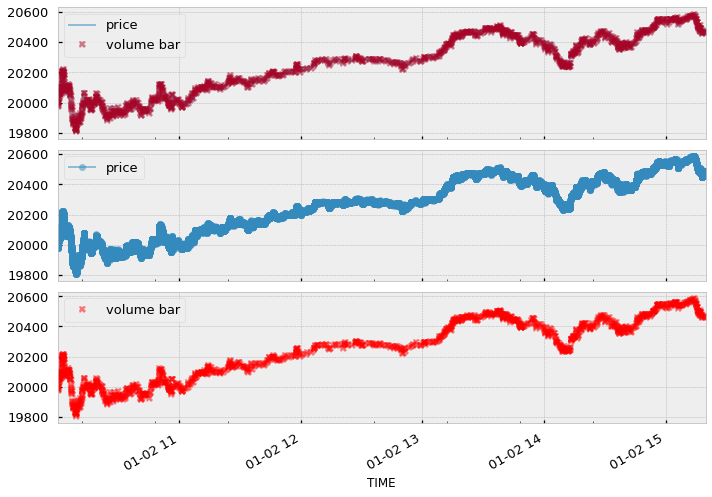

In [19]:
xdf, xtdf = select_sample_data(df, df_vbar, 'PRICE', '2018-01-02')
plot_sample_data(xdf, xtdf, 'volume bar', alpha=0.5, markersize=7)

## Dollar Volume Bar 

In [20]:
def dollar_bars(df, dv_col, n): 
    '''
    compute dollar bars 
    '''
    t = df[dv_col]
    tick_n = 0
    idx = []
    for i, x in enumerate(tqdm(t)): 
        tick_n += x 
        if tick_n >= n: 
            idx.append(i)
            tick_n = 0
            continue
    
    return df.iloc[idx]
        
    
    
    

In [21]:
df_dvbar = dollar_bars(df, 'DV', 1_000_000_000)

100%|██████████| 11946001/11946001 [00:05<00:00, 2343137.15it/s]


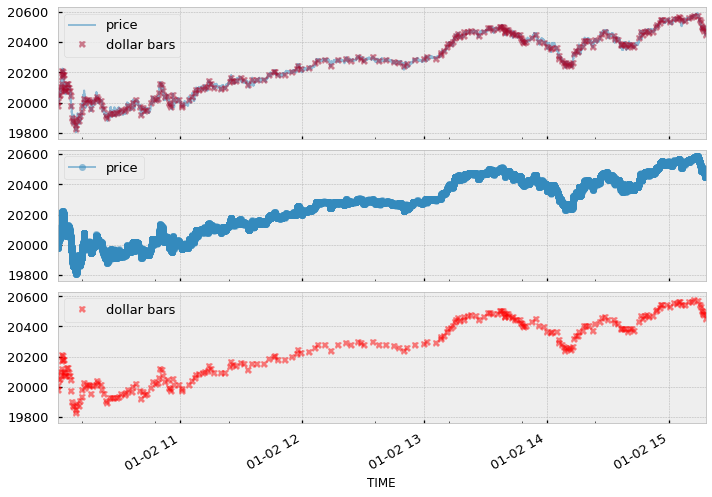

In [22]:
xdf, xtdf = select_sample_data(df, df_dvbar, 'PRICE', '2018-01-02')
plot_sample_data(xdf, xtdf, 'dollar bars', alpha=0.5, markersize=7)

## Tick Imbalance Bars(TIB)

In [13]:
@jit(nopython=True)
def numba_isclose(a,b,rel_tol=1e-09,abs_tol=0.0):
    return np.fabs(a-b) <= np.fmax(rel_tol*np.fmax(np.fabs(a), np.fabs(b)), abs_tol)

@jit(nopython=True)
def bt(p0, p1, b0): 
#     if math.isclose((p1-p0), 0.0, abs_tol=0.001): 
    if numba_isclose((p1-p0), 0.0, abs_tol=0.001):
        b = b0
        return b
    else: 
        b = np.abs(p1-p0)/(p1-p0)
        return b

@jit(nopython=True)
def get_imbalance(t): 
    bs = np.zeros_like(t)
    for i in np.arange(1, bs.shape[0]): 
        t_bt = bt(t[i-1], t[i], bs[i-1])
        bs[i-1] = t_bt
        
    return bs[:-1] # remove last value

@jit(nopython=True)
def test_t_abs(absTheta, t, E_bs): 
    """
    Bool function to test inequlity 
    * row is assumed to come from df.itertuples()
    - absTheta: float(), row.absTheta
    - t: pd.Timestamp()
    - E_bs: float(), row.E_bs
    """
    return (absTheta >= t * E_bs)

def agg_imbalance_bars_(df): 
    """
    Implements the accumulation logic 
    원본: 최적화전의 구버전 
    """
    start = df.index[0]
    bars = [] 
    for row in df.itertuples(): 
        t_abs = row.absTheta
        rowIdx = row.Index
        E_bs = row.E_bs 
        
        t = df.loc[start:rowIdx].shape[0]
        if t < 1: t = 1
        if test_t_abs(t_abs, t, E_bs): 
            bars.append((start, rowIdx, t))
            start = rowIdx
    
    return bars



@jit(nopython=True)
def agg_imb_bars(tm_arr, ts_arr, abs_theta_arr, e_bs_arr): 
    bars = []
    start_i = 0
    last_i = 0
    last_tm = tm_arr[0]
    last_ts = ts_arr[1]
    n_tick = len(tm_arr)
    
    for i in np.arange(n_tick): 
        t_abs = abs_theta_arr[i]
        t_e_bs = e_bs_arr[i]
        tm = tm_arr[i]
        
        if tm > last_tm:
            last_i = i
            last_tm = tm 
            last_ts += ts_arr[i]
            
        if test_t_abs(t_abs, last_ts, t_e_bs): 
            bars.append( (tm_arr[start_i], tm, last_ts) )
            start_i = i
            last_ts = ts_arr[i]
            
    return bars

In [14]:
bs = get_imbalance(df.PRICE.values)
df_bs = pd.DataFrame(bs, index=df.index[:-1], columns=['bs'])

In [15]:
wndo = df_bs.shape[0] // 1000 
print(f"window size: {wndo:,.2f}")

E_bs = df_bs.ewm(wndo).mean() 
E_T = pd.Series(range(df_bs.shape[0]), index=df_bs.index).ewm(wndo).mean()

window size: 11,946.00


In [16]:
df0 = (pd.DataFrame()
       .assign(E_T=E_T)
       .assign(E_bs=E_bs)
       .assign(absMul=lambda df: df.E_T * np.abs(df.E_bs))
       .assign(absTheta=df_bs.cumsum().abs())       
      )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efc06d4b080>,
      dtype=object)

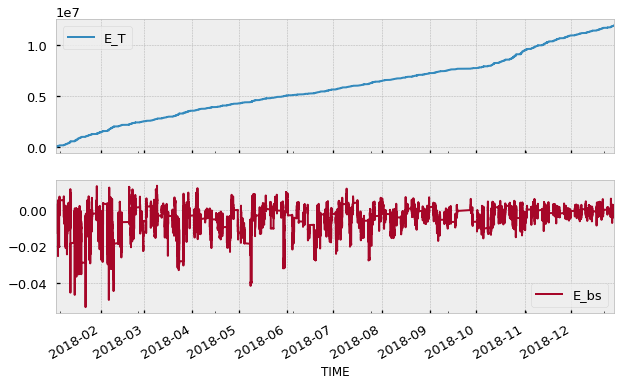

In [312]:
# df0[['E_T', 'E_bs']].plot(subplots=True, figsize=(10, 6)) 
# df0[df0['E_bs'] < 0.1][['E_T', 'E_bs']].plot(subplots=True, figsize=(10, 6)) 
df0.loc['2018-01-03':][['E_T', 'E_bs']].plot(subplots=True, figsize=(10, 6)) 


In [17]:
# df0_1 = df0[:100000]
df0_1 = df0
df0_1_ts = df0_1.groupby(['TIME'])['E_T'].count()
df0_1_ts = df0_1_ts.rename('ts')
df0_1_j = pd.merge(df0_1, df0_1_ts, left_index=True, right_index=True)

In [18]:
%%time
tm_arr = df0_1_j.index.values
ts_arr = df0_1_j['ts'].values
abs_theta_arr = df0_1_j['absTheta'].values
e_bs_arr = df0_1_j['E_bs'].values

bars = agg_imb_bars(tm_arr, ts_arr, abs_theta_arr, e_bs_arr)

CPU times: user 1.98 s, sys: 934 ms, total: 2.91 s
Wall time: 2.91 s


In [19]:
df_imb_bars = (pd.DataFrame(bars, columns=['start', 'stop', 'Ts'])
                 .drop_duplicates()
)

In [42]:
imb_bars_1 = df_imb_bars.stop

In [49]:
%%time
df_imb = df.loc[imb_bars_1].drop_duplicates()

CPU times: user 1min 47s, sys: 3min 1s, total: 4min 48s
Wall time: 4min 48s


In [43]:
%%time
df_imb_price = df.PRICE.loc[imb_bars_1].drop_duplicates()

CPU times: user 1min 46s, sys: 3min, total: 4min 46s
Wall time: 4min 46s


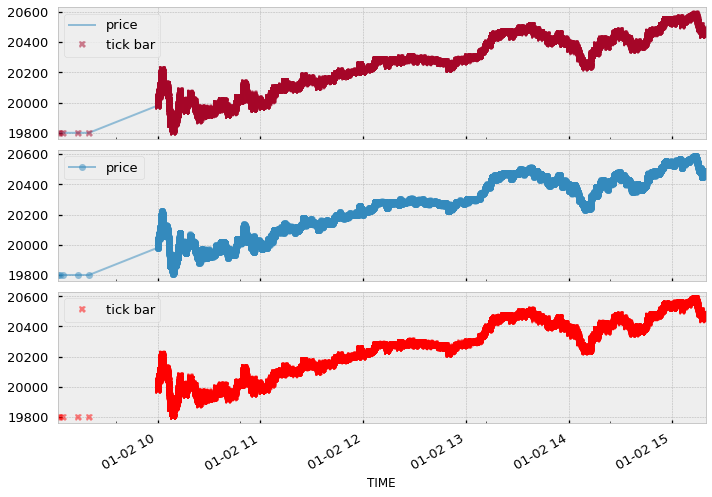

In [51]:
xdf, xtdf = select_sample_data(df, df_imb, 'PRICE', '2018-01-02')
plot_sample_data(xdf, xtdf, 'tick bar', alpha=0.5, markersize=7)

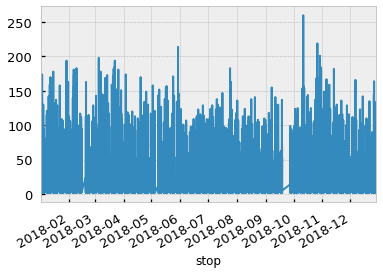

In [314]:
df_imb_bars.set_index('stop')['Ts'].plot()


## DIB(Dollar Imbalance Bars)

# APPENDIX

### agg_imb_bar 최적화 검증

In [ ]:
df0 = (pd.DataFrame()
       .assign(E_T=E_T)
       .assign(E_bs=E_bs)
       .assign(absMul=lambda df: df.E_T * np.abs(df.E_bs))
       .assign(absTheta=df_bs.cumsum().abs())       
      )

In [273]:
# 10만 개만 뽑아서 값을 대조해본다
df0_1 = df0[:100000]
df0_1_ts = df0_1.groupby(['TIME'])['E_T'].count()
df0_1_ts = df0_1_ts.rename('ts')
df0_1_j = pd.merge(df0_1, df0_1_ts, left_index=True, right_index=True)

In [274]:
%%time
bars = agg_imbalance_bars_(df0_1)

CPU times: user 28.6 s, sys: 49.1 ms, total: 28.7 s
Wall time: 28.6 s


In [278]:
%%time
tm_arr = df0_1.index.values
ts_arr = df0_1_j['ts'].values
abs_theta_arr = df0_1['absTheta'].values
e_bs_arr = df0_1['E_bs'].values

test_bars = agg_imb_bars(tm_arr, ts_arr, abs_theta_arr, e_bs_arr)

CPU times: user 36.4 ms, sys: 11 µs, total: 36.4 ms
Wall time: 35.7 ms


In [281]:
print(len(bars), len(test_bars))

99992 99992


In [282]:
# 검증 
t0 = test_bars[0]
b0 = bars[0]

bars_start = [b[0] for b in bars]
bars_end = [b[1] for b in bars]
bars_start= pd.DatetimeIndex(bars_start).astype('int')
bars_end = pd.DatetimeIndex(bars_end).astype('int')
bars_ts = [b[2] for b in bars]

test_start = [t[0].astype('int') for t in test_bars]
test_end = [t[1].astype('int') for t in test_bars]
test_ts = [t[2] for t in test_bars]

In [283]:
for t, i in enumerate(zip(bars_start, bars_end, bars_ts, test_start, test_end, test_ts)): 
    if i[0] != i[3] or i[1] != i[4] or i[2] != i[5]: 
        print(f"t={t}, bar = ({(i[0], i[1], i[2])}), test = ({(i[3], i[4], i[5])}),")
